In [1]:
import numpy as np

from scipy.io import loadmat
from scipy import optimize

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import NonUniformImage
from matplotlib import cm
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures

%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(0)

In [3]:
pathToDataFile = 'ex5data1.mat'

In [4]:
data = loadmat(pathToDataFile)
print(type(data))
print(data.keys())
print(data['X'].shape)
print(type(data['X']))
print(data['y'].shape)

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])
(12, 1)
<class 'numpy.ndarray'>
(12, 1)


# 1 Regularised Linear Regression

## 1.1 Data Extraction and Transformation

In [5]:
def getData(pathToDataFile, xLabel, yLabel):
    data = loadmat(pathToDataFile)
    X = np.insert(data[xLabel], 0, 1, axis=1)
    sampleSize, nVariables = X.shape
    y = data[yLabel]
    return X.flatten(), y.flatten(), sampleSize, nVariables

def getBeta(nVariables):
    beta = np.zeros(nVariables)
    return beta

## 1.2 Data Visualisation

In [6]:
def visualiseData(pathToDataFile, xLabel, yLabel, title):
    data = loadmat(pathToDataFile)
    plt.plot(data[xLabel], data[yLabel], 'o')
    plt.xlabel("Change in water level (x)")
    plt.ylabel("Water flowing out of the dam (y)")
    plt.title(title)
    return plt.show()

### 1.2.1 Training Set

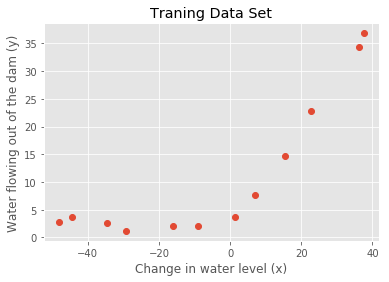

In [7]:
visualiseData(pathToDataFile, 'X', 'y', 'Traning Data Set')

### 1.2.2 Validation Set

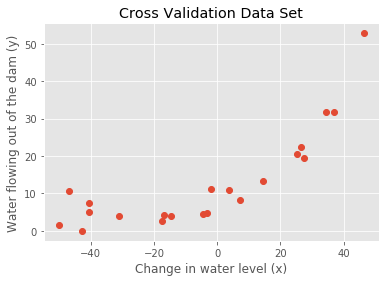

In [8]:
visualiseData(pathToDataFile, 'Xval', 'yval', 'Cross Validation Data Set')

### 1.2.3 Test Set

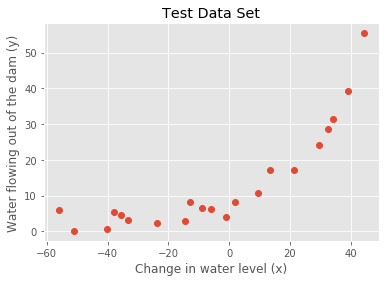

In [9]:
visualiseData(pathToDataFile, 'Xtest', 'ytest', 'Test Data Set')

## 1.3 Regularised Linear Regression

**Hypothesis** $h_{\beta}(X) =  X\cdot\beta$

**Error** $e = (h_{\beta}(X) - y)$

**Cost Function** $J = \frac{1}{2n}{\sum(h_{\beta} - y)^2}$

**Regularisation Term** $R = \frac{\lambda}{2n}{\sum{\beta}^2}$

**Regularised Cost** $J = \frac{1}{2n}{\sum(h_{\beta} - y)^2} + \frac{\lambda}{2n}{\sum{\beta}^2}$

**Gradient** $\frac{\partial J}{\partial \beta _0} = \frac{1}{n}X^{T}\cdot e$<br\>
$\frac{\partial J}{\partial \beta _{≠0}} = \frac{1}{n}X^{T}\cdot e + \frac{\lambda}{n}\beta$<br\>

In the code $\frac{\partial J}{\partial \beta}$ is denoted symply as **g**.

In [10]:
def hypothesis(beta, X, sampleSize, nVariables):
    beta = beta.reshape(nVariables, -1)
    X = X.reshape(sampleSize, -1)
#     return hypothesis vector h(n, 1), where n is sampleSize
    return np.dot(X, beta)

def costFunction(beta, X, y, sampleSize, nVariables, iLambda=0.):
    beta = beta.reshape(nVariables, -1)
    X = X.reshape(sampleSize, -1)
    y = y.reshape(sampleSize, -1)
#     hypothesis vector h(n, 1)
    h = hypothesis(beta, X, sampleSize, nVariables)
#     cost scalar J(1, 1); technically the result is an array (1,1) rather than a float
    J = np.dot((y-h).T, y-h)/(2*sampleSize)
#     similarly cost J can be calculated using np.sum
#     J = np.sum((y-h)**2)/(2*sampleSize)
    R = iLambda*np.dot(beta.T, beta)/(2*sampleSize)
    return (J + R)[0][0]

def gradient(beta, X, y, sampleSize, nVariables, iLambda=0.):
    beta = beta.reshape(nVariables, -1)
    X = X.reshape(sampleSize, -1)
    y = y.reshape(sampleSize, -1)
#     hypothesis vector h(n, 1)
    h = hypothesis(beta, X, sampleSize, nVariables)
#     error vector e(n, 1) = h(n, 1) - y(n, 1)
    e = h - y
#     gradient vector g(k, 1) = X(n, k).T*e(n, 1)*
    g = np.dot(X.T,e)/(sampleSize)
#     regularisation term vector (r(400x1)) — derivative of the regularisation term of the cost funtion
    r = beta[1:]*(iLambda/sampleSize)
    g[1:] = g[1:] + r
    return g.flatten()

def plotRegression(beta, X, y, sampleSize, nVariables):  
    beta = beta.reshape(nVariables, -1)
    X = X.reshape(sampleSize, -1)
    y = y.reshape(sampleSize, -1)
    
    yFit = np.dot(X, beta)
    
    MSE = np.sum((y - yFit)**2)/y.shape[0]
    
    plt.plot(X[:,1:], y, 'o', X[:,1:], yFit, '-')
    plt.xlabel("X")
    plt.ylabel("Y")
    print ("β_0:", beta[0][0],
           "\nβ_1:", beta[1][0],
           "\nRegression: Y =", '{:10.2f}'.format(beta[0][0]), '+', '{:10.2f}'.format(beta[1][0]), "X"
           "\nMSE =",'{:10.2f}'.format(MSE))
    return plt.show()

## Function Test
For the trainin set and the $\beta$-vector set to ones the output of the functions should be as follows:<br\>
costFunction — J = 303.951525554<br\>
gradient — gradient = [ -15.30301567  598.16741084]

In [11]:
X, y, sampleSize, nVariables = getData(pathToDataFile, 'X', 'y')
beta = getBeta(nVariables)
betaOnes = np.ones(nVariables)
# print("hypothesis =", hypothesis(flatBetaOnes, flatX, sampleSize, nVariables))
print("J =", costFunction(betaOnes, X, y, sampleSize, nVariables, iLambda=0.))
print("gradient =", gradient(betaOnes, X, y, sampleSize, nVariables, iLambda=0.))

J = 303.951525554
gradient = [ -15.30301567  598.16741084]


In [12]:
def betaOptimisation(flatBeta, flatX, flatY, sampleSize, nVariables, iLambda=0.):

    betaOptimisation = optimize.minimize(costFunction, flatBeta,
                                      args=(flatX, flatY, sampleSize, nVariables, iLambda),
                                      method=None, jac=gradient, options={'maxiter':50})
    betaOpt = betaOptimisation['x']

#     betaOptimisation = optimize.fmin_cg(costFunction, fprime=gradient, x0=flatBeta,
#                                      args=(flatX, flatY, sampleSize, nVariables, iLambda),
#                                      maxiter=50, disp=False, full_output=True)
#     flatBeta = betaOptimisation[0]
    return betaOpt

In [13]:
betaOpt = betaOptimisation(beta, X, y, sampleSize, nVariables)
print (betaOpt)

[ 13.08790351   0.36777923]


β_0: 13.0879035109 
β_1: 0.367779229746 
Regression: Y =      13.09 +       0.37 X
MSE =      44.75


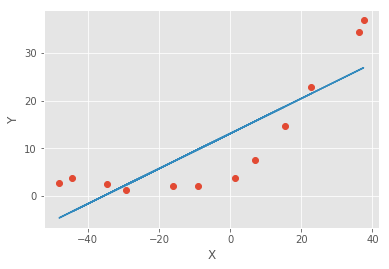

In [14]:
plotRegression(betaOpt, X, y, sampleSize, nVariables)

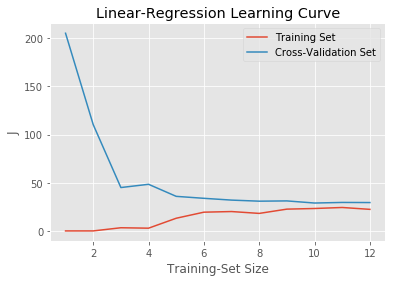

In [15]:
X, y, sampleSize, nVariables = getData(pathToDataFile, 'X', 'y')
X_val, y_val, sampleSize_val, nVariables_val = getData(pathToDataFile, 'Xval', 'yval')
beta = getBeta(nVariables)

J_test = []
J_val = []
for i in range(sampleSize):
#     np.random.seed(0)
#     indexSet = np.random.choice(sampleSize, i+1, replace=False)
#     subsetX = reshapeT(X, sampleSize)[indexSet]
#     subsetY = reshapeT(y, sampleSize)[indexSet]
    subsetX = X.reshape(sampleSize, -1)[:i+1,:]
    subsetY = y.reshape(sampleSize, -1)[:i+1]
    flatSubsetX = subsetX.flatten()
    flatSubsetY = subsetY.flatten()
    betaFit = betaOptimisation(beta, flatSubsetX, flatSubsetY, i+1, nVariables)
    yFit_test = np.dot(subsetX, betaFit)
    J_test += [costFunction(betaFit, flatSubsetX, flatSubsetY, i+1, nVariables, iLambda=0.)]
    
    yFit_val = np.dot(X_val.reshape(sampleSize_val, -1), betaFit)
    J_val += [costFunction(betaFit, X_val, y_val, sampleSize_val, nVariables_val, iLambda=0.)]

plt.plot(range(1,sampleSize + 1), J_test, '-', label='Training Set')
plt.plot(range(1,sampleSize + 1), J_val, '-', label='Cross-Validation Set')
plt.xlabel("Training-Set Size")
plt.ylabel("J")
plt.title("Linear-Regression Learning Curve")
plt.legend()
plt.show()

In [16]:
def polynomialsANDinteractions(pathToDataFile, xLabel, yLabel, polynomialDegree):
    data = loadmat(pathToDataFile)
    X = data[xLabel]
    y = data[yLabel]
    poly = PolynomialFeatures(polynomialDegree)
    polyX = poly.fit_transform(X)
    sampleSize, nVariables = polyX.shape
    return polyX.flatten(), y.flatten(), sampleSize, nVariables

def normalise(X, sampleSize):
    normalisedX = X.reshape(sampleSize, -1).copy()
    for i in (range(normalisedX.shape[1])):
        if np.std(normalisedX[:,i]) != 0:
            normalisedX[:,i] = (normalisedX[:,i] - np.mean(normalisedX[:,i]))/np.std(normalisedX[:,i])
    return normalisedX.flatten()

In [17]:
polynomialDegree = 8
polyX, y, polySampleSize, polyNVariables = polynomialsANDinteractions(pathToDataFile, 'X', 'y', polynomialDegree)
polyBeta = getBeta(polyNVariables)
normPolyX = normalise(polyX, polySampleSize)
normY = normalise(y, polySampleSize)
print(polySampleSize)
print(polyNVariables)
print(np.max(normPolyX))

12
9
2.88908181993


[ -6.71383010e-16   8.83572359e-01   1.65030044e+00   1.11363909e+00
  -3.34178136e+00  -3.19209768e+00   2.99447999e+00   2.86241752e+00
  -1.05521662e-01]


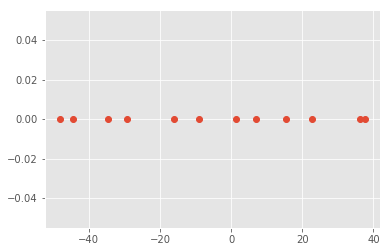

In [18]:
betaOpt_poly = betaOptimisation(polyBeta, normPolyX, normY, polySampleSize, polyNVariables)
print (betaOpt_poly)
# def plotRegression(beta, X, y, sampleSize, nVariables):  
polyBeta = polyBeta.reshape(polyNVariables, -1)
polyX = polyX.reshape(sampleSize, -1)
y = normY.reshape(sampleSize, -1)

yFit = np.dot(polyX, polyBeta)

MSE = np.sum((y - yFit)**2)/y.shape[0]

plt.plot(polyX[:,1:2], yFit, 'o')
# plt.plot(polyX[:,1:2], y, 'o', X[:,1:2], yFit, '-')
# plt.xlabel("X")
# plt.ylabel("Y")
# print ("β_0:", beta[0][0],
#        "\nβ_1:", beta[1][0],
#        "\nRegression: Y =", '{:10.2f}'.format(beta[0][0]), '+', '{:10.2f}'.format(beta[1][0]), "X"
#        "\nMSE =",'{:10.2f}'.format(MSE))
plt.show()